In [1]:
import pandas as pd
import numpy as np
census_race_df_subboro = pd.read_csv('data/census_race_df_subboro.csv')
cdfis_subboro = pd.read_csv('data/cdfis_subboro.csv')
nyc_banks_subboro = pd.read_csv('data/nyc_banks_subboro.csv')
nyc_banks = pd.read_csv('data/nyc_banks_subboro.csv')

In [2]:
for type_cdfi in cdfis_subboro['Financial Institution Type'].unique():
    name_cdfi = type_cdfi.replace(" ", "")
    subboro_type_cdfi = cdfis_subboro[cdfis_subboro['Financial Institution Type'] == type_cdfi].groupby(['Sub Boro Name',]).count()['tract']
    census_race_df_subboro[name_cdfi] = census_race_df_subboro['Sub_Boro_Name'].map(subboro_type_cdfi, na_action='ignore')
    census_race_df_subboro[name_cdfi] = census_race_df_subboro[name_cdfi].fillna(0)

### Potentially use reference sub-boro

In [3]:
# 2 norm dist
def distance_checker(row_base, row):
    return np.linalg.norm(row_base - row)

In [4]:
reference = 'Bushwick'
ref_row = census_race_df_subboro[census_race_df_subboro['Sub_Boro_Name'] == reference]

def dist_for_all(row, column_set=['Hispanic', 'White', 'Black', 'Native', 'Asian']):
    return distance_checker(ref_row[column_set], row[column_set])

column_set=['Hispanic', 'White', 'Black', 'Native', 'Asian', '%_Poor_2013']
column_set_all_dem = ['Hispanic', 'White', 'Black', 'Native', 'Asian','Median_income_2013','Unemployment_2013','%_Poor_2013']

census_race_df_subboro['dem_dist_bushwick'] = census_race_df_subboro.apply(lambda row: dist_for_all(row, column_set), axis=1)

In [5]:
census_race_df_subboro = census_race_df_subboro.rename({'%_Poor_2013':'Percent_Poor_2013'}, axis=1)

### Create control for all us banks

In [6]:
nyc_banks = nyc_banks.drop('Unnamed: 0', axis=1)

In [7]:
bank_class_values = list(nyc_banks['BKCLASS'].unique())
bank_class_values

['N', 'SI', 'SM', 'NM', 'SB', 'OI']

In [8]:
df_counts_banks = nyc_banks.groupby(['Sub Boro Name','BKCLASS']).count()
df_counts_banks = df_counts_banks.rename({'ADDRESS':'bank_type_count'}, axis=1)
df_counts_banks = df_counts_banks[['bank_type_count']]

In [9]:
def other_banks_count(row, bank_class):
    try:
        return df_counts_banks.loc[row['Sub_Boro_Name'], bank_class][0]
    except:
        return 0

for cls in bank_class_values:
    census_race_df_subboro[cls + '_Bank'] = census_race_df_subboro.apply(lambda row: other_banks_count(row, bank_class=cls), axis=1)

In [10]:
census_race_df_subboro['aggregate_other_bank'] = census_race_df_subboro[['N_Bank','SI_Bank', 'SM_Bank', 'NM_Bank','SB_Bank', 'OI_Bank']].sum(axis=1)

In [11]:
census_race_df_subboro['aggregate_brick_and_mortar_cdfi'] = census_race_df_subboro[['CreditUnion','BankorThrift','BankHoldingCompany']].sum(axis=1)
census_race_df_subboro['aggregate_other_cdfi'] = census_race_df_subboro[['VentureCapital','LoanFund']].sum(axis=1)

## How predictive is a CDCU of lower unbankedness?

In [12]:
df = census_race_df_subboro[census_race_df_subboro['White'] < 0.5]

In [13]:
# Normalize median income
max_value = df['Median_income_2013'].max()
min_value = df['Median_income_2013'].min()
df['Median_income_2013'] = (df['Median_income_2013'] - min_value) / (max_value - min_value)

/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_64780/2054980947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Median_income_2013'] = (df['Median_income_2013'] - min_value) / (max_value - min_value)


In [14]:
# df[['LoanFund','CreditUnion','BankorThrift','BankHoldingCompany','VentureCapital']]
# LoanFund + CreditUnion + BankorThrift + BankHoldingCompany + VentureCapital

In [16]:
df

,Unnamed: 0,Hispanic,White,Black,Native,Asian,Sub_Boro_Name,Unbanked_2013,Underbanked_2013,Median_income_2013,...,dem_dist_bushwick,N_Bank,SI_Bank,SM_Bank,NM_Bank,SB_Bank,OI_Bank,aggregate_other_bank,aggregate_brick_and_mortar_cdfi,aggregate_other_cdfi
0,0,0.685007,0.016946,0.279119,0.002544,0.008180,Mott Haven / Hunts Point,0.31,0.30,0.000000,...,0.241280,10,1,1,1,1,0,14,0.0,1.0
1,1,0.579638,0.028504,0.294561,0.001569,0.068948,Soundview / Parkchester,0.22,0.29,0.172484,...,0.175276,10,0,1,0,2,0,13,2.0,0.0
2,2,0.688496,0.014521,0.270150,0.001263,0.015460,University Heights / Fordham,0.30,0.33,0.021895,...,0.231518,3,1,0,0,0,0,4,0.0,0.0
3,3,0.631895,0.016260,0.317884,0.005016,0.015933,Highbridge / S. Concourse,0.26,0.34,0.061410,...,0.217638,4,2,0,1,1,0,8,2.0,0.0
4,4,0.635721,0.046448,0.296285,0.002456,0.007544,Morrisania / East Tremont,0.28,0.31,0.021858,...,0.222689,6,1,1,0,0,0,8,1.0,0.0
5,5,0.361729,0.315302,0.272254,0.002367,0.030157,Throgs Neck / Co-op City,0.10,0.27,0.612914,...,0.368659,11,4,0,2,0,0,17,0.0,0.0
6,6,0.449122,0.227821,0.222382,0.000258,0.080579,Pelham Parkway,0.15,0.28,0.371585,...,0.218407,15,6,1,0,0,0,22,0.0,0.0
7,7,0.672237,0.078020,0.162238,0.001881,0.065865,Kingsbridge Heights / Mosholu,0.24,0.31,0.111260,...,0.133147,11,1,1,0,0,0,13,0.0,0.0
8,8,0.456937,0.339737,0.129162,0.002283,0.051895,Riverdale / Kingsbridge,0.11,0.26,0.697576,...,0.292843,12,2,0,0,1,0,15,0.0,0.0
9,9,0.227401,0.074226,0.653739,0.002756,0.022297,Williamsbridge / Baychester,0.16,0.35,0.419129,...,0.628709,6,1,0,0,0,0,7,0.0,0.0


In [17]:
from statsmodels.regression.linear_model import WLS

def wls_model(df, form, name):
    model = WLS.from_formula(
        form,
        data=df,
        #freq_weights=np.array(self.WEIGHTS.array)
    )
    regression = model.fit(method='pinv')
    return regression.summary2()

summary = wls_model(
    df,
    'Aggregate_Banking ~ aggregate_brick_and_mortar_cdfi + aggregate_other_cdfi + Hispanic + White + Black + Asian + Percent_Poor_2013 + Unemployment_2013 + Median_income_2013 + aggregate_other_bank',
    'non_white'
)

In [18]:
summary

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Weighted least squares
===============================================================================
Model:                   WLS                  Adj. R-squared:        0.962     
Dependent Variable:      Aggregate_Banking    AIC:                   -181.1909 
Date:                    2022-12-20 14:10     BIC:                   -162.6133 
No. Observations:        40                   Log-Likelihood:        101.60    
Df Model:                10                   F-statistic:           99.82     
Df Residuals:            29                   Prob (F-statistic):    1.06e-19  
R-squared:               0.972                Scale:                 0.00050242
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                        0.0533   0.1782  0.2990 0.7671 -0.3111  0.4177
aggregate_brick_and_mortar_cdfi -0.0144   0.0077 -1.8605 0.0730 -0.0301  0.0014
aggregate_other_cdfi            -0.0006   0.0073 -0.0772 0.9390 -0.0155  0.0144
Hispanic                         0.5048   0.1742  2.8981 0.0071  0.1485  0.8610
White                            0.1984   0.1729  1.1470 0.2607 -0.1553  0.5520
Black                            0.5214   0.1722  3.0270 0.0051  0.1691  0.8736
Asian                            0.1532   0.1881  0.8145 0.4220 -0.2315  0.5380
Percent_Poor_2013                0.1132   0.1025  1.1049 0.2783 -0.0964  0.3228
Unemployment_2013                0.1376   0.2016  0.6824 0.5004 -0.2747  0.5498
Median_income_2013              -0.0989   0.0332 -2.9763 0.0058 -0.1668 -0.0309
aggregate_other_bank            -0.0003   0.0005 -0.6806 0.5015 -0.0013  0.0007
-------------------------------------------------------------------------------
Omnibus:                   0.133             Durbin-Watson:               1.826
Prob(Omnibus):             0.935             Jarque-Bera (JB):            0.015
Skew:                      -0.033            Prob(JB):                    0.993
Kurtosis:                  2.931             Condition No.:               2260 
===============================================================================
* The condition number is large (2e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

## Plot access to banks by race

/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_64780/25724849.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_predominantly = census_race_df_subboro.groupby('predominantly').mean()


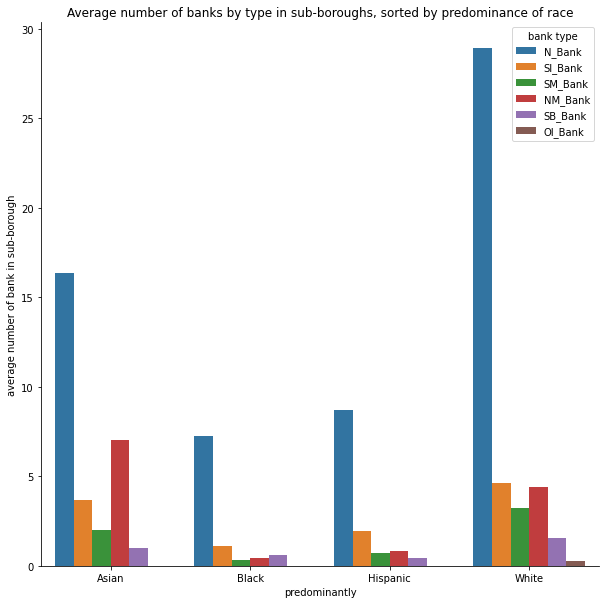

In [19]:
def predominantly(row):
    _max = -1.0
    race = ''
    for col in ['Hispanic', 'White', 'Black', 'Native','Asian']:
        if row[col] > _max:
            race = col
            _max = row[col]
    return race

census_race_df_subboro['predominantly'] = census_race_df_subboro.apply(lambda row: predominantly(row), axis=1)
df_predominantly = census_race_df_subboro.groupby('predominantly').mean()
df_plot = df_predominantly.reset_index()
df_plot = df_plot[['predominantly', 'N_Bank','SI_Bank', 'SM_Bank', 'NM_Bank','SB_Bank', 'OI_Bank']] # 'Aggregate_Banking']]
import seaborn as sns
import matplotlib.pyplot as plt 
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = df_plot.melt(id_vars='predominantly', value_name='average number of bank in sub-borough', var_name='bank type')
sns.barplot(x='predominantly', y='average number of bank in sub-borough', hue='bank type', data=tidy, ax=ax1)
plt.title('Average number of banks by type in sub-boroughs, sorted by predominance of race')
sns.despine(fig)